In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt
from joblib import Parallel, delayed

In [2]:
# Load data
notebook = "real1_Abalone_init_pipeline"
experiment_results = np.load(f'store/{notebook}.npz', allow_pickle=True)
n_runs = experiment_results['metadata'].item()['n_runs']

In [3]:
def process_run(run_id, default_sigmas_data, mtmh_sigmas_data):
    """Process a single run for change point detection"""
    # Get sigma data for this specific run
    default_sigmas = default_sigmas_data[run_id]
    mtmh_sigmas = mtmh_sigmas_data[run_id]
    
    # Change point detection using Dynp algorithm
    model_default = rpt.Binseg(model="linear").fit(default_sigmas.reshape(-1, 1))
    default_changepoints = model_default.predict(n_bkps=1)

    model_mtmh = rpt.Binseg(model="linear").fit(mtmh_sigmas.reshape(-1, 1))
    mtmh_changepoints = model_mtmh.predict(n_bkps=1)
    
    return {
        'run_id': run_id,
        'default_sigmas': default_sigmas,
        'mtmh_sigmas': mtmh_sigmas,
        'default_changepoints': default_changepoints,
        'mtmh_changepoints': mtmh_changepoints
    }

In [4]:
# Extract sigma data arrays before parallel processing
default_sigmas_data = experiment_results['default'].item()['sigmas']
mtmh_sigmas_data = experiment_results['mtmh'].item()['sigmas']

# Parallel processing of all runs
results = Parallel(n_jobs=n_runs)(
    delayed(process_run)(run_id, default_sigmas_data, mtmh_sigmas_data) 
    for run_id in range(n_runs)
)

Run 0:
  Default BART change points: [195]
  MTMH BART change points: [3450]
Run 1:
  Default BART change points: [45]
  MTMH BART change points: [5735]
Run 2:
  Default BART change points: [70]
  MTMH BART change points: [845]
Run 3:
  Default BART change points: [6075]
  MTMH BART change points: [5105]
Run 4:
  Default BART change points: [4745]
  MTMH BART change points: [4690]


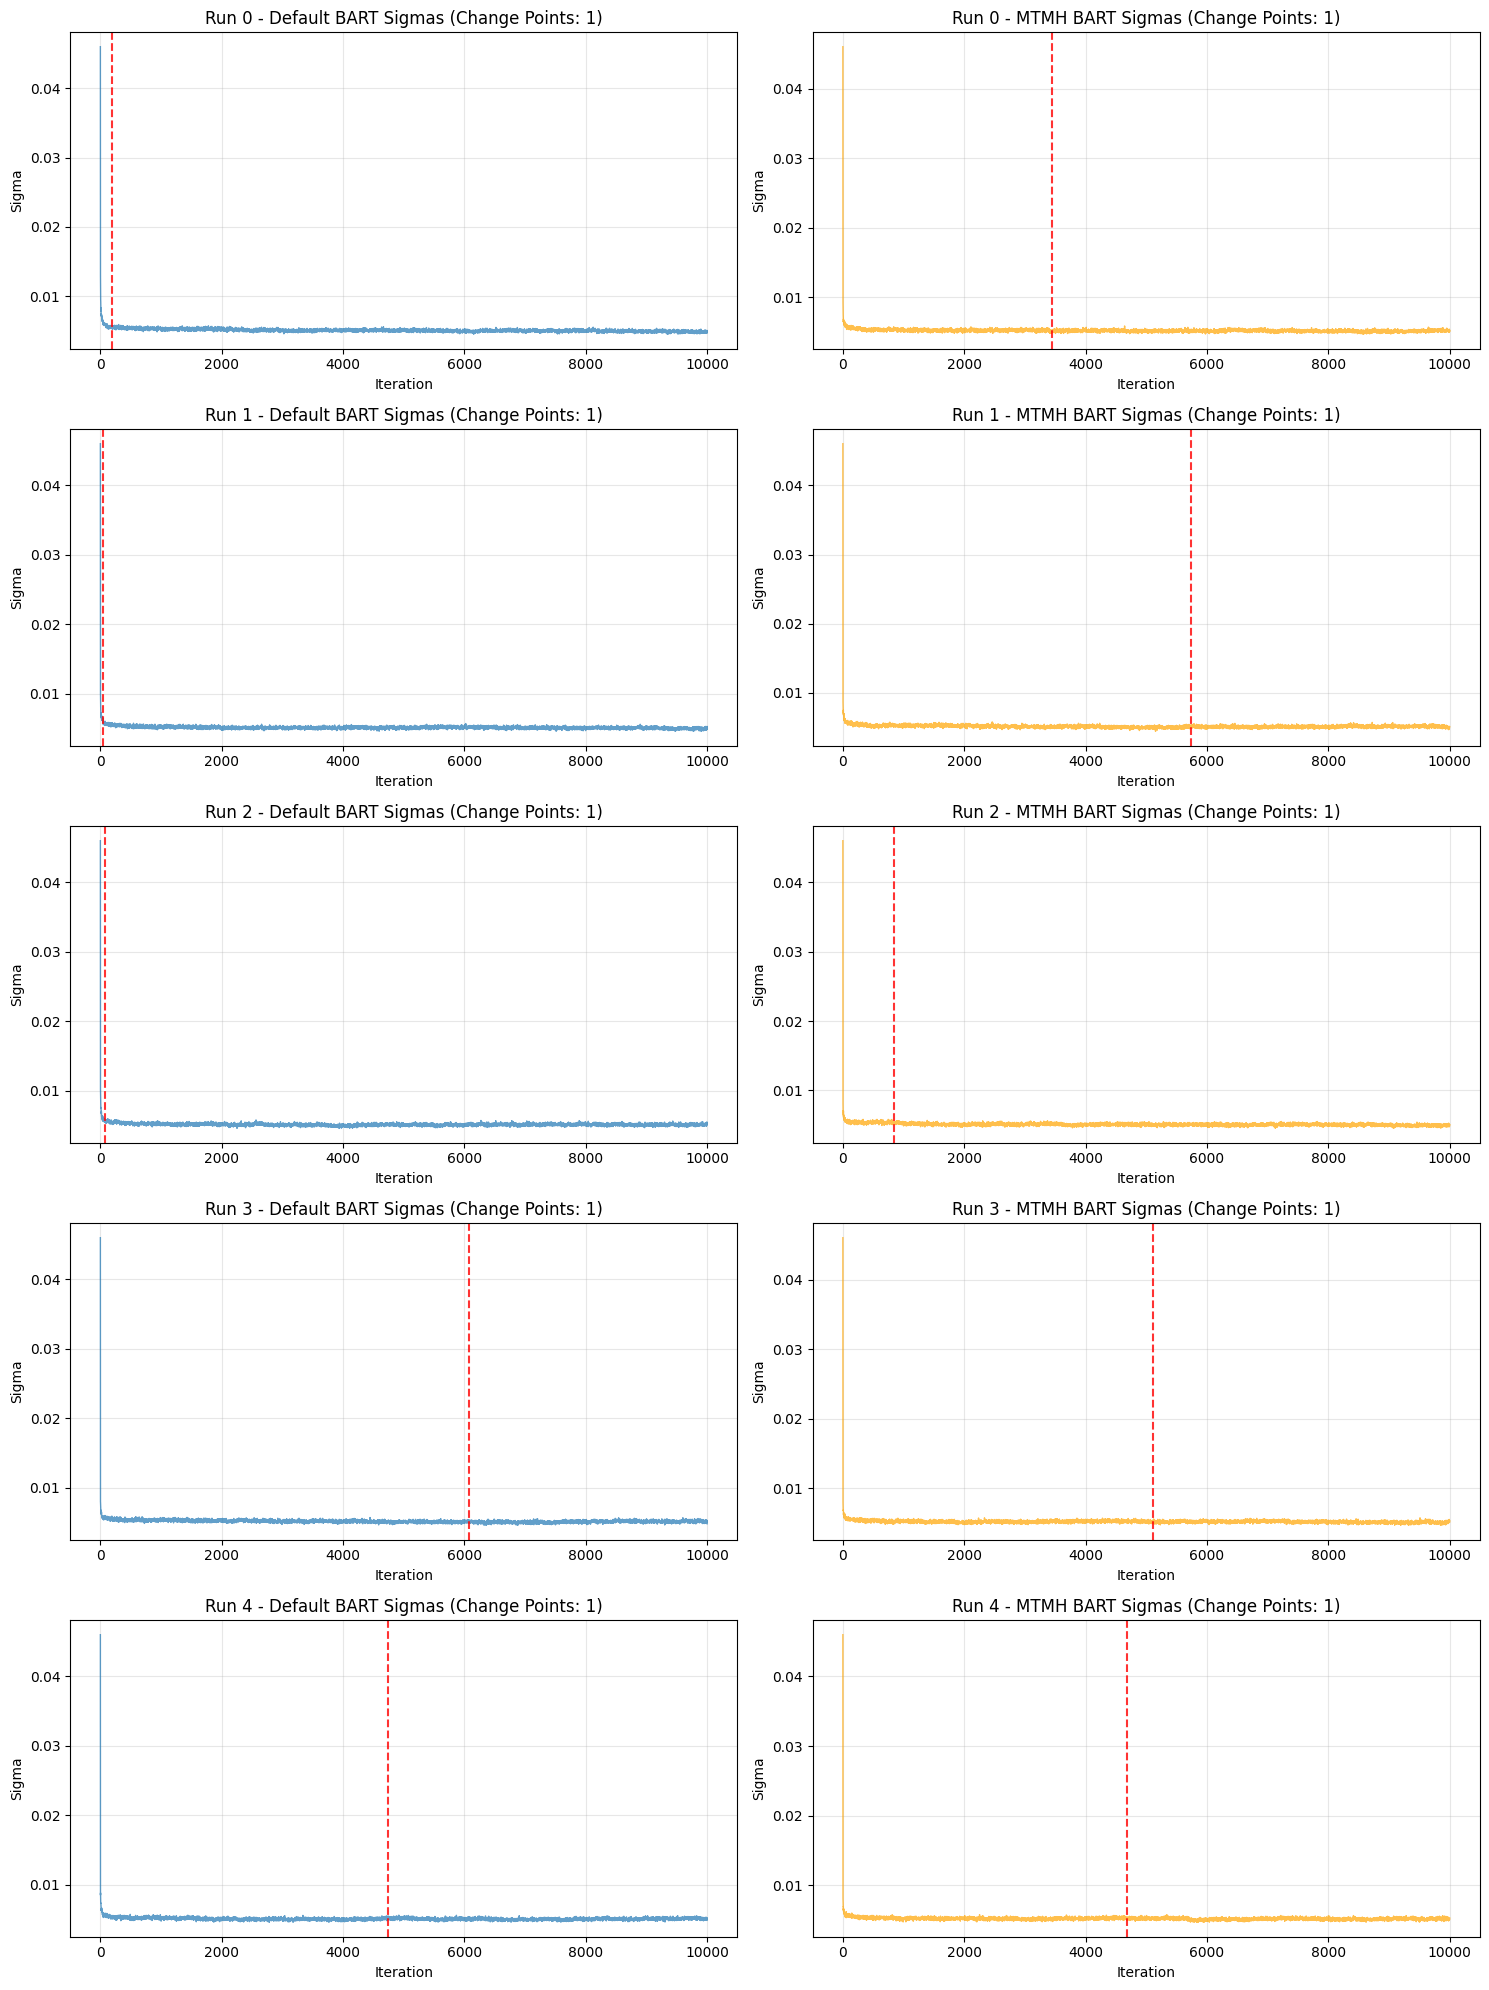

In [5]:
# Create subplots for visualization
fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

# Plot results
for result in results:
    run_id = result['run_id']
    
    # Plot Default BART
    axes[run_id, 0].plot(result['default_sigmas'], alpha=0.7, linewidth=1)
    for cp in result['default_changepoints'][:-1]:
        axes[run_id, 0].axvline(cp, color='red', linestyle='--', alpha=0.8)
    axes[run_id, 0].set_title(f'Run {run_id} - Default BART Sigmas (Change Points: {len(result["default_changepoints"])-1})')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigma')
    axes[run_id, 0].grid(True, alpha=0.3)
    
    # Plot MTMH BART
    axes[run_id, 1].plot(result['mtmh_sigmas'], alpha=0.7, linewidth=1, color='orange')
    for cp in result['mtmh_changepoints'][:-1]:
        axes[run_id, 1].axvline(cp, color='red', linestyle='--', alpha=0.8)
    axes[run_id, 1].set_title(f'Run {run_id} - MTMH BART Sigmas (Change Points: {len(result["mtmh_changepoints"])-1})')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Sigma')
    axes[run_id, 1].grid(True, alpha=0.3)
    
    # Print change point information
    print(f"Run {run_id}:")
    print(f"  Default BART change points: {result['default_changepoints'][:-1]}")
    print(f"  MTMH BART change points: {result['mtmh_changepoints'][:-1]}")

plt.tight_layout()
plt.show()

Run 0:
  Default BART change points: [7341]
  MTMH BART change points: [216]
Run 1:
  Default BART change points: [6336]
  MTMH BART change points: [2451]
Run 2:
  Default BART change points: [6736]
  MTMH BART change points: [16]
Run 3:
  Default BART change points: [4606]
  MTMH BART change points: [9506]
Run 4:
  Default BART change points: [6601]
  MTMH BART change points: [6366]


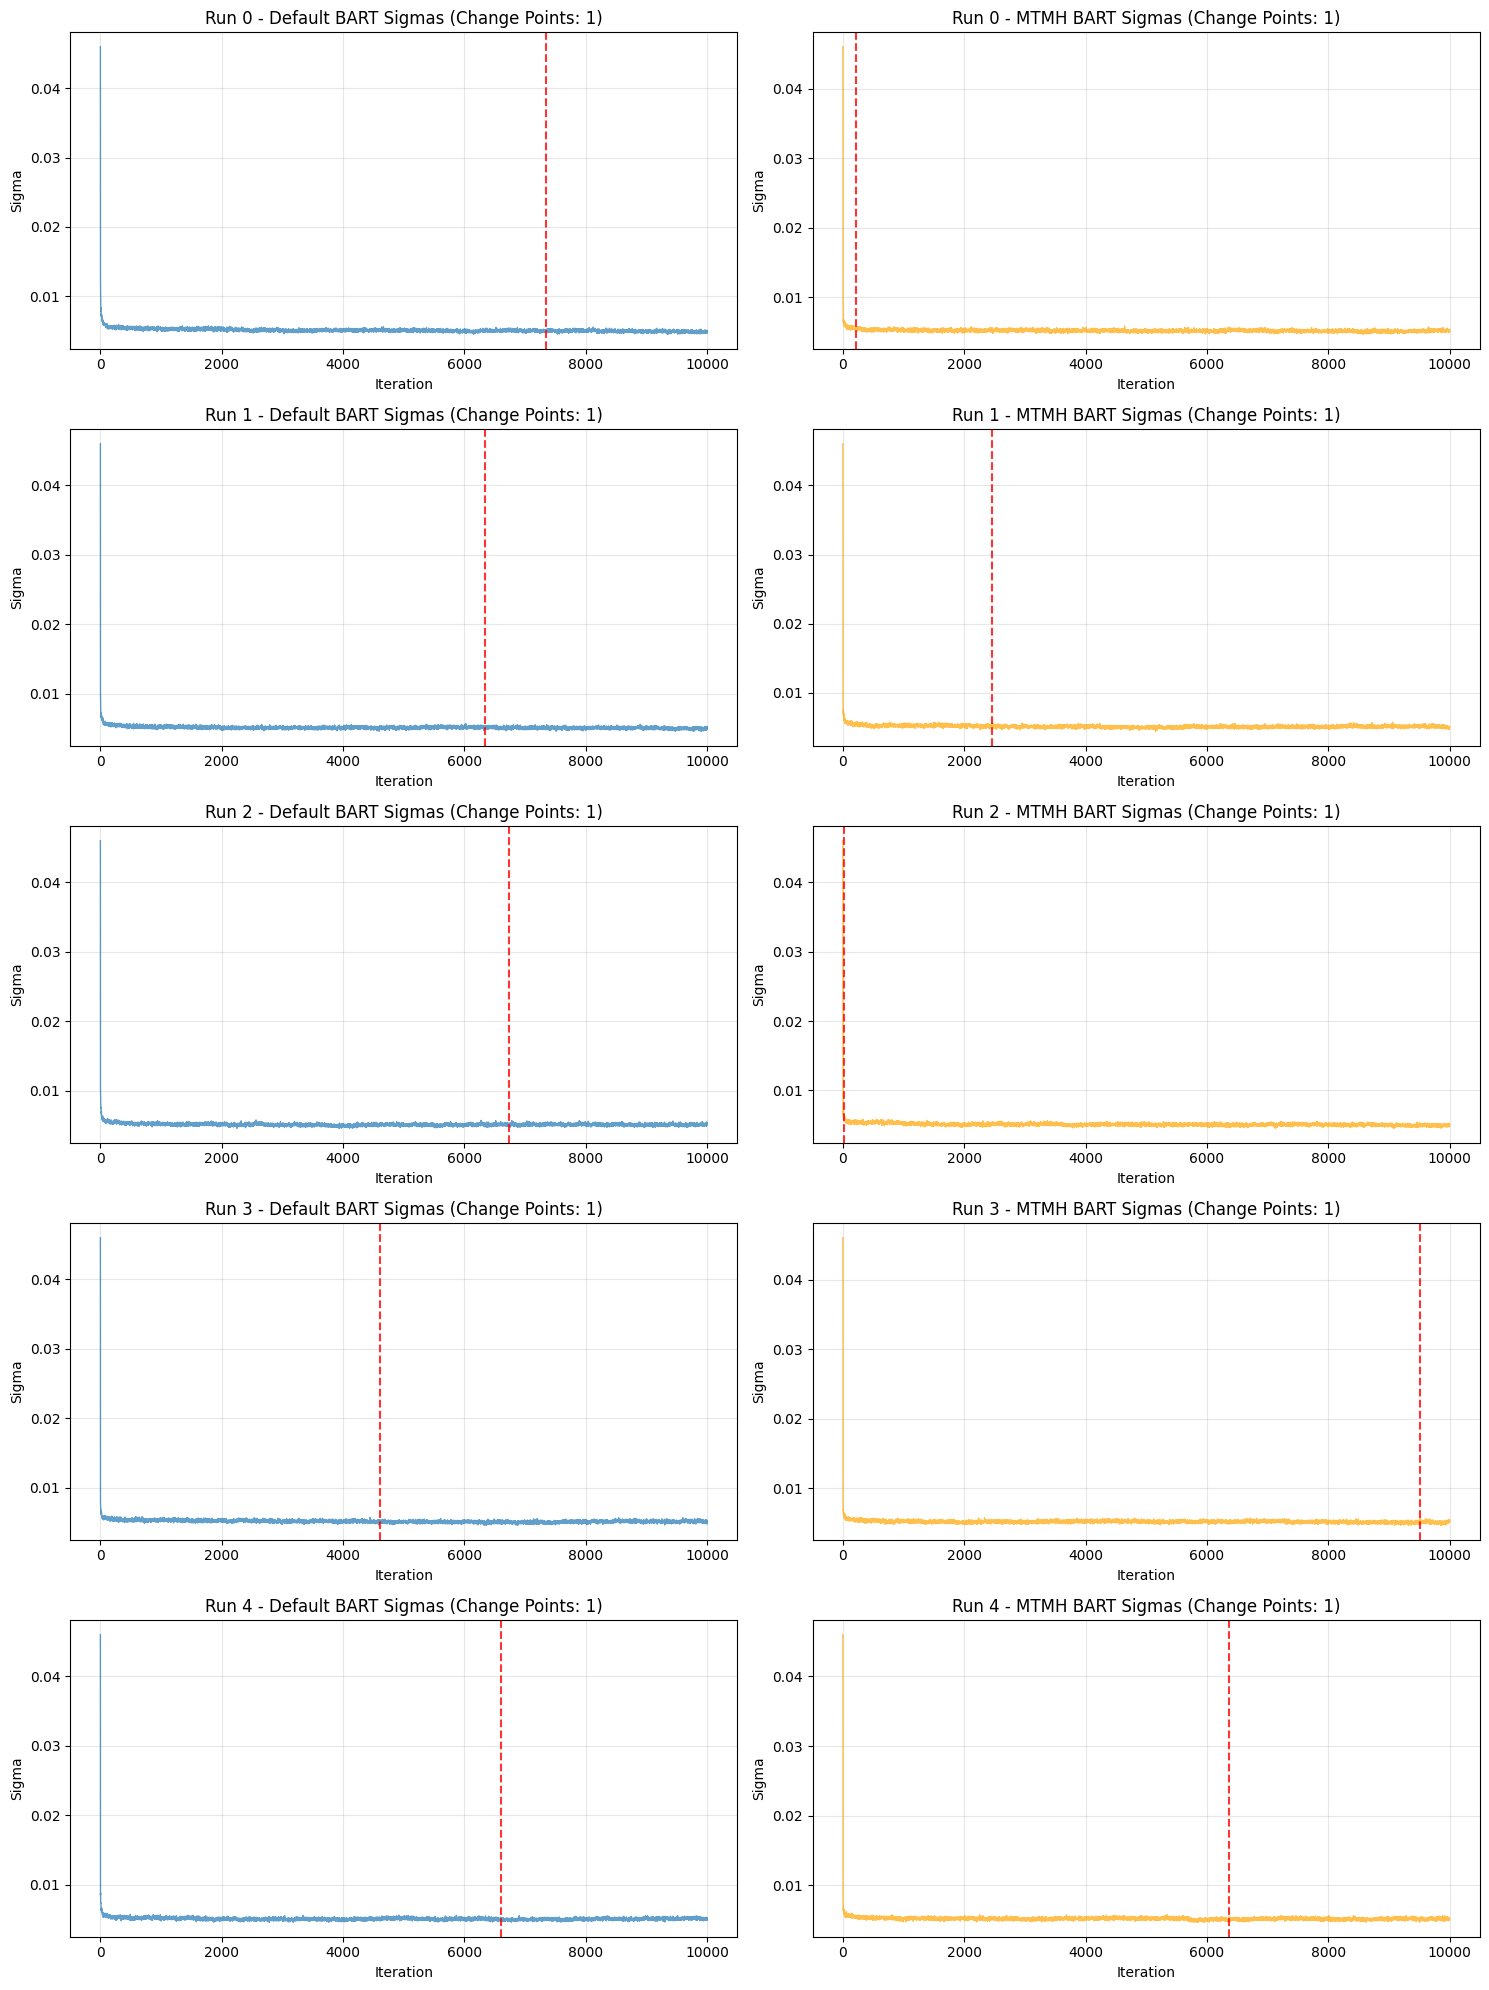

In [6]:
def process_run(run_id, default_sigmas_data, mtmh_sigmas_data):
    """Process a single run for change point detection"""
    # Get sigma data for this specific run
    default_sigmas = default_sigmas_data[run_id]
    mtmh_sigmas = mtmh_sigmas_data[run_id]

    # Reverse the chains
    default_sigmas_rev = default_sigmas[::-1]
    mtmh_sigmas_rev = mtmh_sigmas[::-1]

    # Change point detection on reversed chains
    model_default = rpt.Binseg(model="linear").fit(default_sigmas_rev.reshape(-1, 1))
    default_changepoints_rev = model_default.predict(n_bkps=1)
    # Map change points back to original order
    default_changepoints = [len(default_sigmas) - cp for cp in default_changepoints_rev]

    model_mtmh = rpt.Binseg(model="linear").fit(mtmh_sigmas_rev.reshape(-1, 1))
    mtmh_changepoints_rev = model_mtmh.predict(n_bkps=1)
    mtmh_changepoints = [len(mtmh_sigmas) - cp for cp in mtmh_changepoints_rev]

    return {
        'run_id': run_id,
        'default_sigmas': default_sigmas,
        'mtmh_sigmas': mtmh_sigmas,
        'default_changepoints': default_changepoints,
        'mtmh_changepoints': mtmh_changepoints
    }

# Extract sigma data arrays before parallel processing
default_sigmas_data = experiment_results['default'].item()['sigmas']
mtmh_sigmas_data = experiment_results['mtmh'].item()['sigmas']

# Parallel processing of all runs
results = Parallel(n_jobs=n_runs)(
    delayed(process_run)(run_id, default_sigmas_data, mtmh_sigmas_data) 
    for run_id in range(n_runs)
)

# Create subplots for visualization
fig, axes = plt.subplots(n_runs, 2, figsize=(15, 4*n_runs))
if n_runs == 1:
    axes = axes.reshape(1, -1)

# Plot results
for result in results:
    run_id = result['run_id']
    
    # Plot Default BART
    axes[run_id, 0].plot(result['default_sigmas'], alpha=0.7, linewidth=1)
    for cp in result['default_changepoints'][:-1]:
        axes[run_id, 0].axvline(cp, color='red', linestyle='--', alpha=0.8)
    axes[run_id, 0].set_title(f'Run {run_id} - Default BART Sigmas (Change Points: {len(result["default_changepoints"])-1})')
    axes[run_id, 0].set_xlabel('Iteration')
    axes[run_id, 0].set_ylabel('Sigma')
    axes[run_id, 0].grid(True, alpha=0.3)
    
    # Plot MTMH BART
    axes[run_id, 1].plot(result['mtmh_sigmas'], alpha=0.7, linewidth=1, color='orange')
    for cp in result['mtmh_changepoints'][:-1]:
        axes[run_id, 1].axvline(cp, color='red', linestyle='--', alpha=0.8)
    axes[run_id, 1].set_title(f'Run {run_id} - MTMH BART Sigmas (Change Points: {len(result["mtmh_changepoints"])-1})')
    axes[run_id, 1].set_xlabel('Iteration')
    axes[run_id, 1].set_ylabel('Sigma')
    axes[run_id, 1].grid(True, alpha=0.3)
    
    # Print change point information
    print(f"Run {run_id}:")
    print(f"  Default BART change points: {result['default_changepoints'][:-1]}")
    print(f"  MTMH BART change points: {result['mtmh_changepoints'][:-1]}")

plt.tight_layout()
plt.show()

# Convergence Analysis
## KPSS test

In [7]:
from diagnosis import segmented_kpss_test

=== Default BART Analysis ===

--- Default Run 0 ---
Sigma convergence analysis:


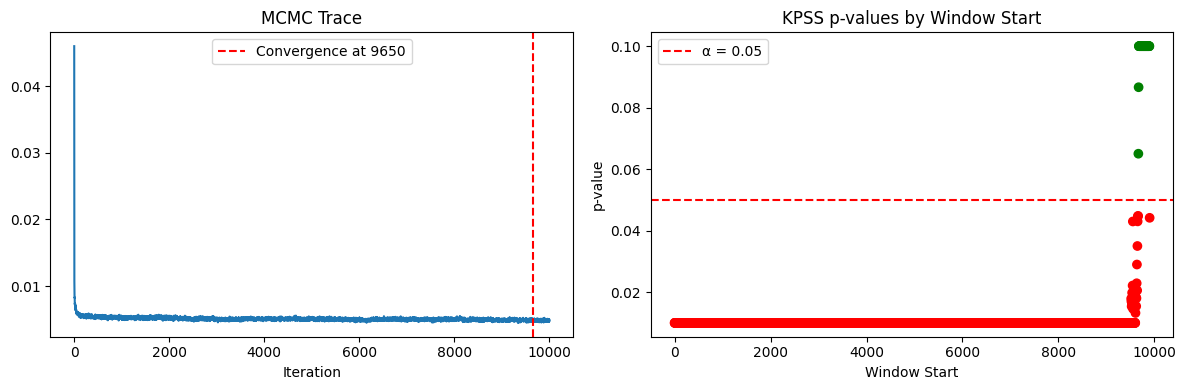

Default Chain converged: True
Convergence at iteration: 9650
Rejection rate: 97.63%

RMSE convergence analysis:


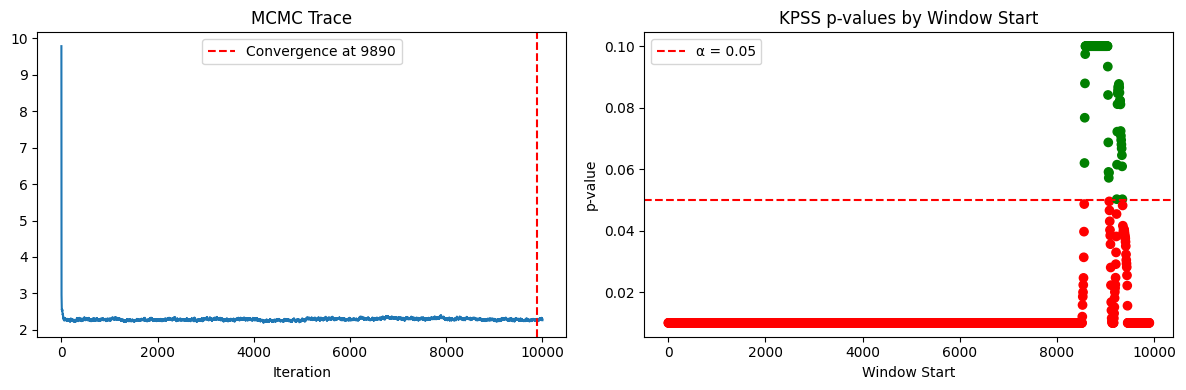

Default Chain converged: True
Convergence at iteration: 9890
Rejection rate: 93.64%

--- Default Run 1 ---
Sigma convergence analysis:


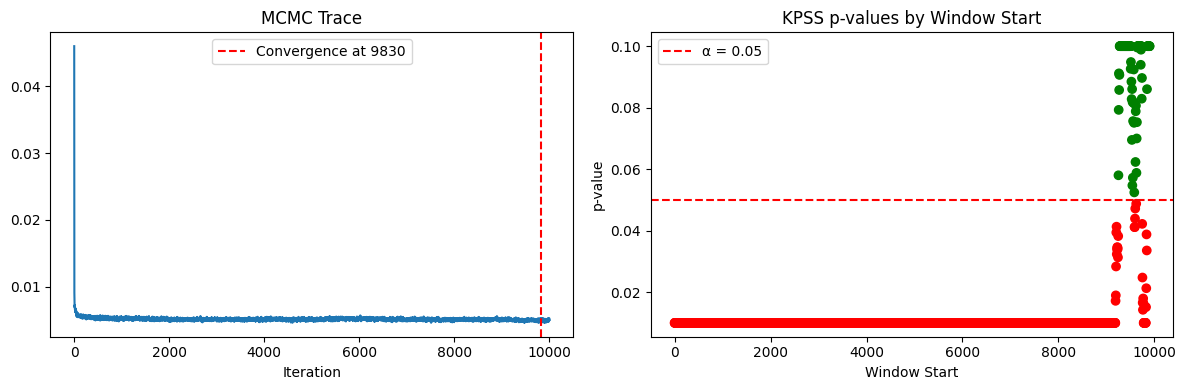

Default Chain converged: True
Convergence at iteration: 9830
Rejection rate: 94.65%

RMSE convergence analysis:


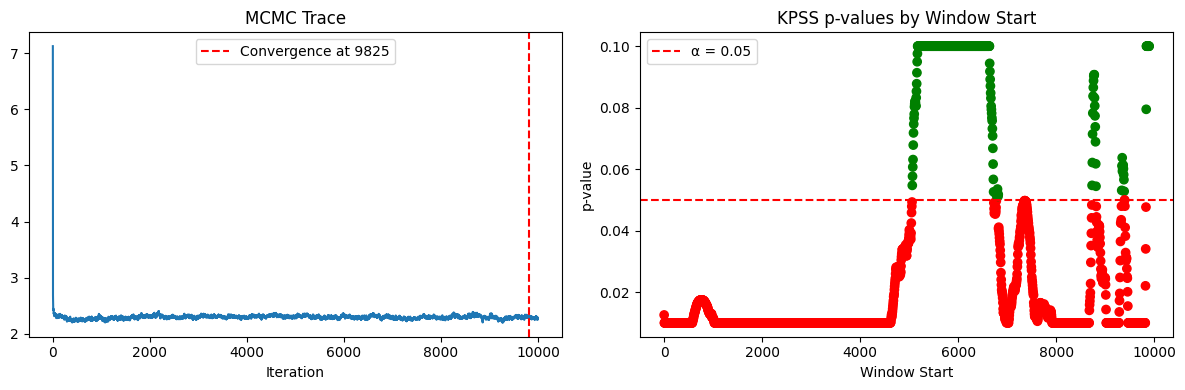

Default Chain converged: True
Convergence at iteration: 9825
Rejection rate: 80.72%

--- Default Run 2 ---
Sigma convergence analysis:


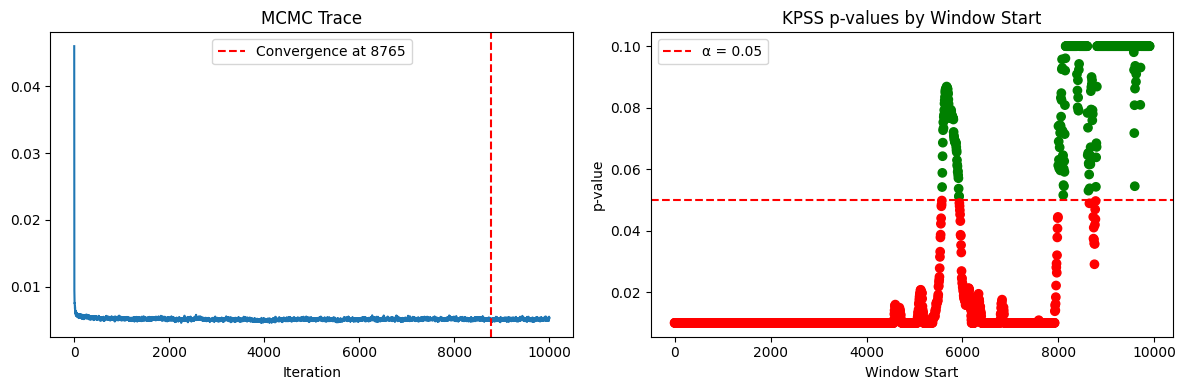

Default Chain converged: True
Convergence at iteration: 8765
Rejection rate: 77.74%

RMSE convergence analysis:


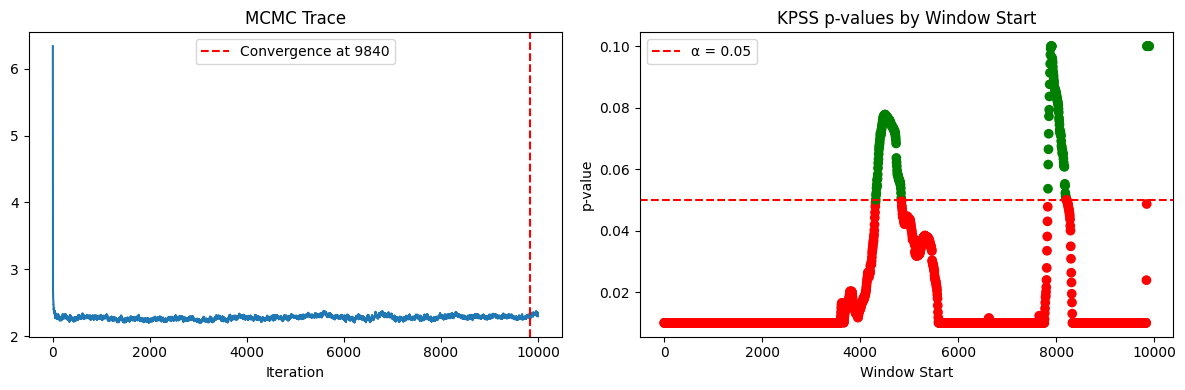

Default Chain converged: True
Convergence at iteration: 9840
Rejection rate: 90.41%

--- Default Run 3 ---
Sigma convergence analysis:


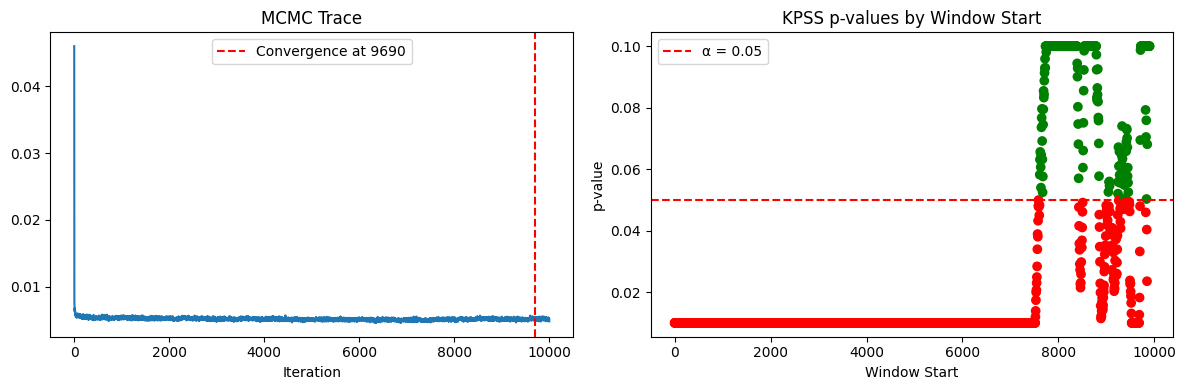

Default Chain converged: True
Convergence at iteration: 9690
Rejection rate: 84.65%

RMSE convergence analysis:


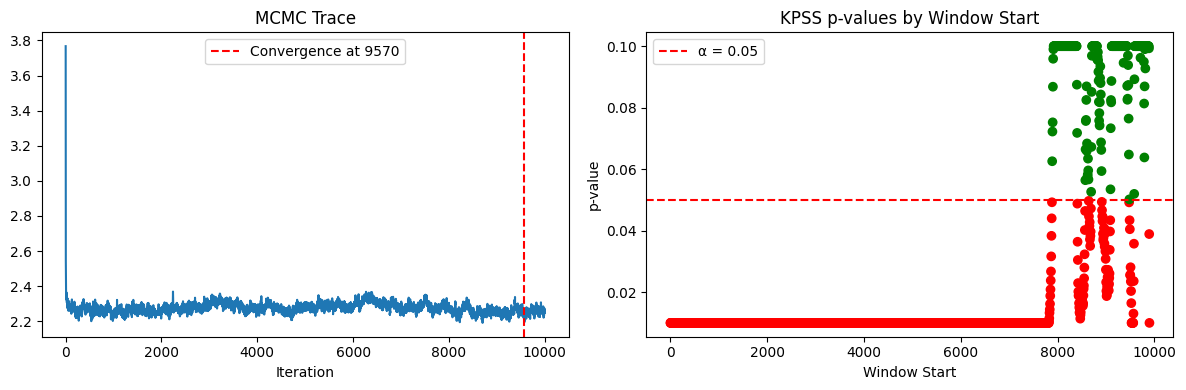

Default Chain converged: True
Convergence at iteration: 9570
Rejection rate: 84.76%

--- Default Run 4 ---
Sigma convergence analysis:


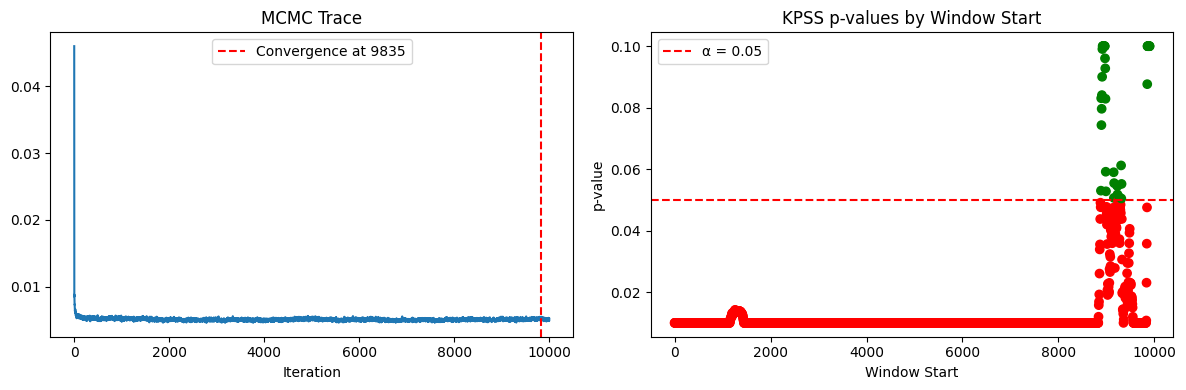

Default Chain converged: True
Convergence at iteration: 9835
Rejection rate: 97.78%

RMSE convergence analysis:


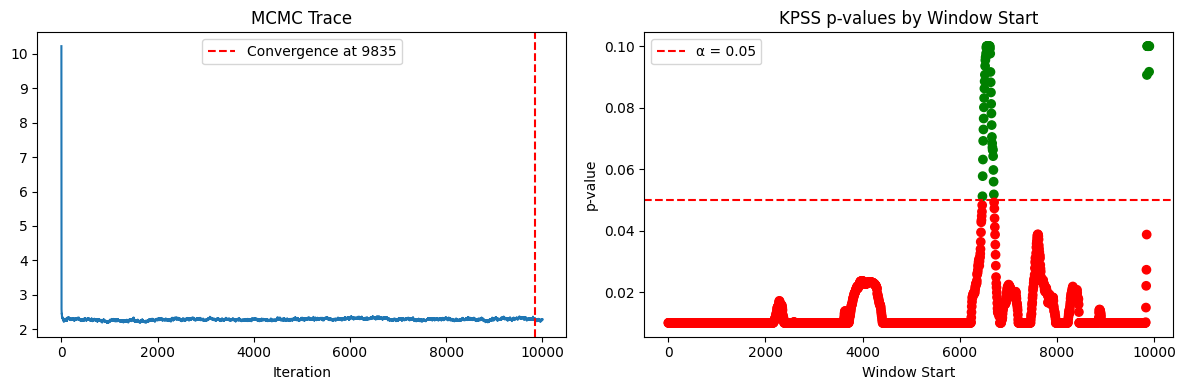

Default Chain converged: True
Convergence at iteration: 9835
Rejection rate: 97.02%


In [8]:
# Analyze each run's results and collect statistics
n_runs = experiment_results['metadata'].item()['n_runs']

# Collect convergence statistics
default_sigma_convergence = []
default_rmse_convergence = []
default_sigma_rates = []
default_rmse_rates = []

# Analyze Default BART results
print("=== Default BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- Default Run {run_id} ---")
    
    # Extract data for this run from the combined arrays
    sigmas = experiment_results['default'].item()['sigmas'][run_id]
    rmses = experiment_results['default'].item()['rmses'][run_id]
    
    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, window_length=100, step=5, alpha=0.05)
    print(f"Default Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Rejection rate: {convergence_result['rejection_rate']:.2%}")
    default_sigma_rates.append(convergence_result['rejection_rate'])
    
    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, window_length=100, step=5, alpha=0.05)
    print(f"Default Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        default_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Rejection rate: {convergence_result['rejection_rate']:.2%}")
    default_rmse_rates.append(convergence_result['rejection_rate'])

=== MTMH BART Analysis ===

--- MTMH Run 0 ---
Sigma convergence analysis:


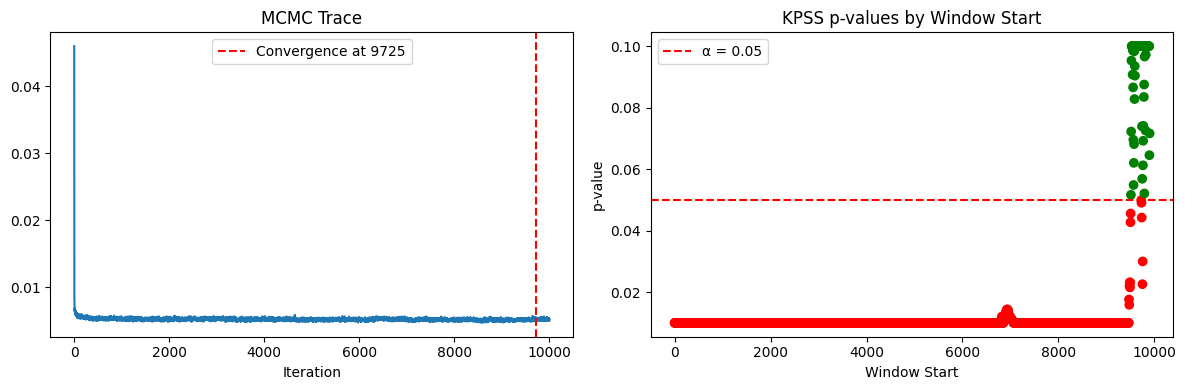

MTMH Chain converged: True
Convergence at iteration: 9725
Rejection rate: 96.26%

RMSE convergence analysis:


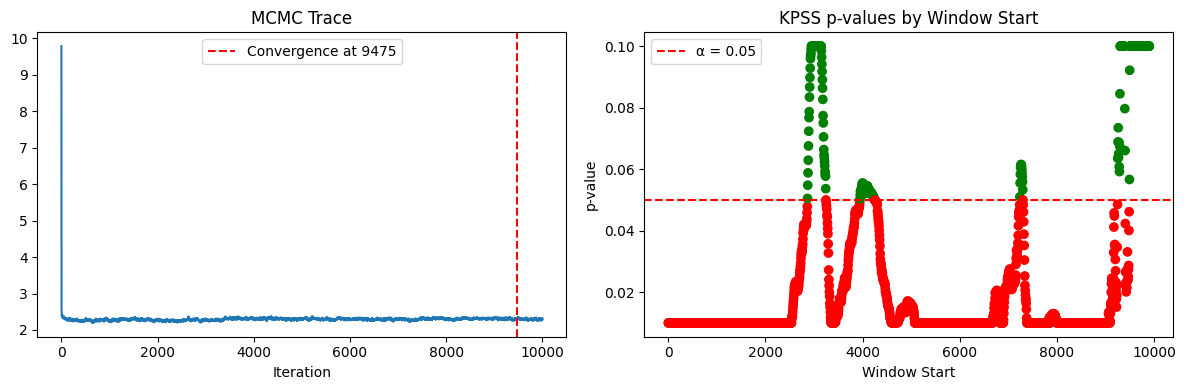

MTMH Chain converged: True
Convergence at iteration: 9475
Rejection rate: 86.67%

--- MTMH Run 1 ---
Sigma convergence analysis:


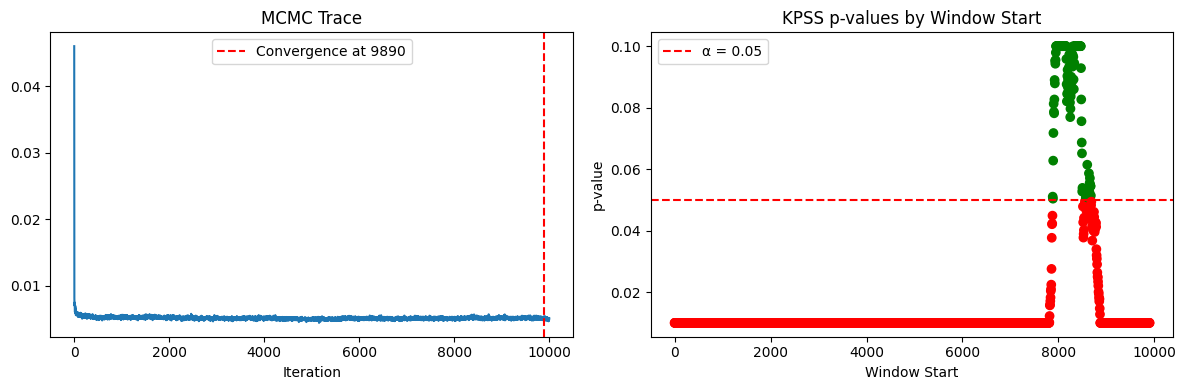

MTMH Chain converged: True
Convergence at iteration: 9890
Rejection rate: 92.93%

RMSE convergence analysis:


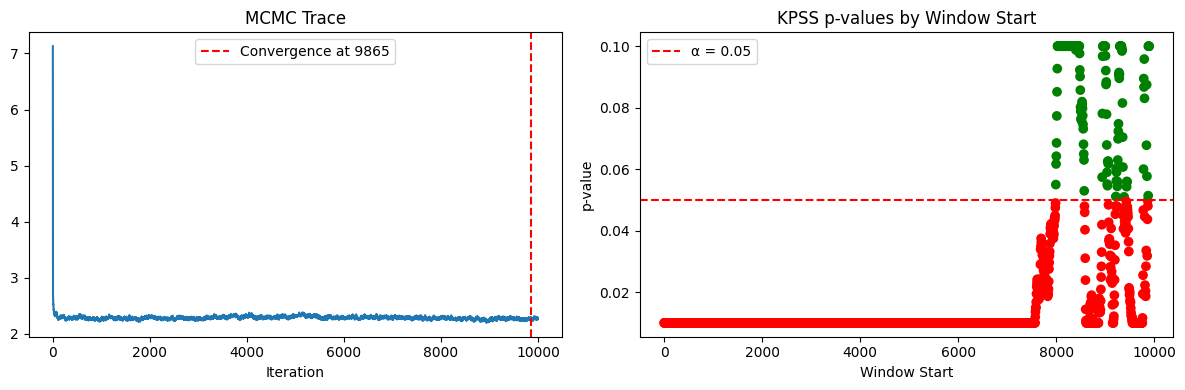

MTMH Chain converged: True
Convergence at iteration: 9865
Rejection rate: 90.51%

--- MTMH Run 2 ---
Sigma convergence analysis:


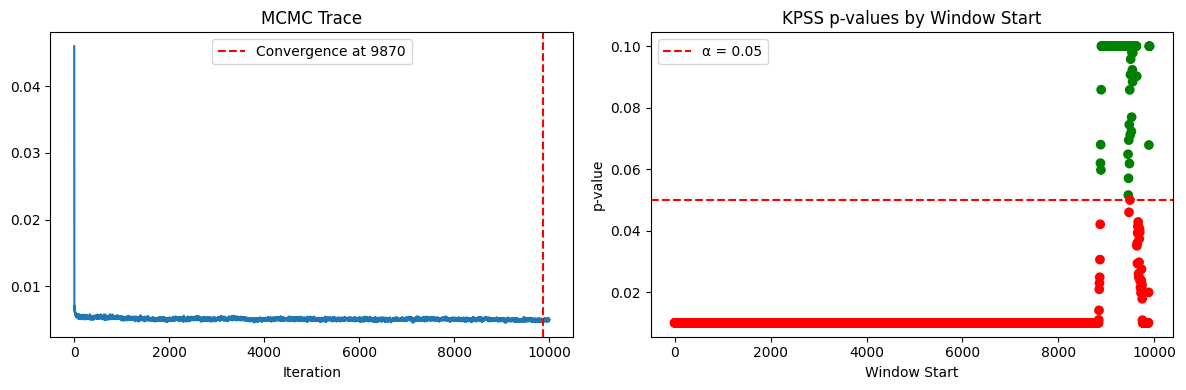

MTMH Chain converged: True
Convergence at iteration: 9870
Rejection rate: 92.23%

RMSE convergence analysis:


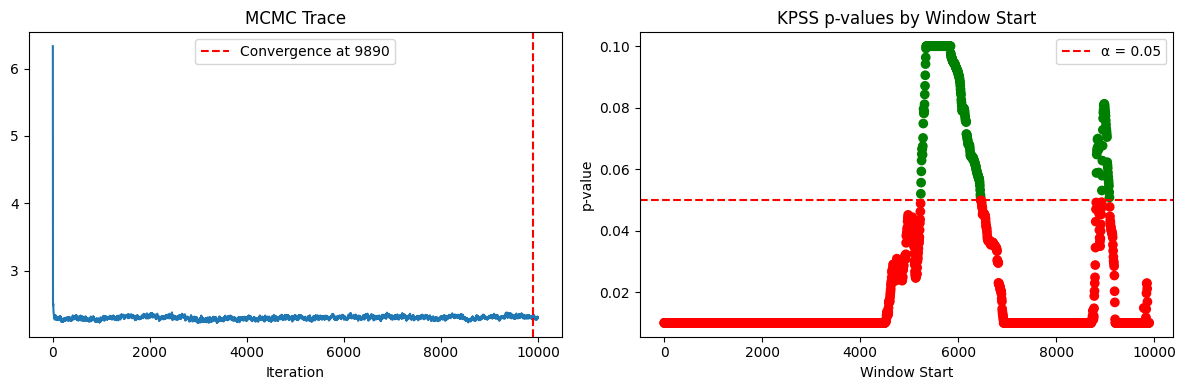

MTMH Chain converged: True
Convergence at iteration: 9890
Rejection rate: 85.51%

--- MTMH Run 3 ---
Sigma convergence analysis:


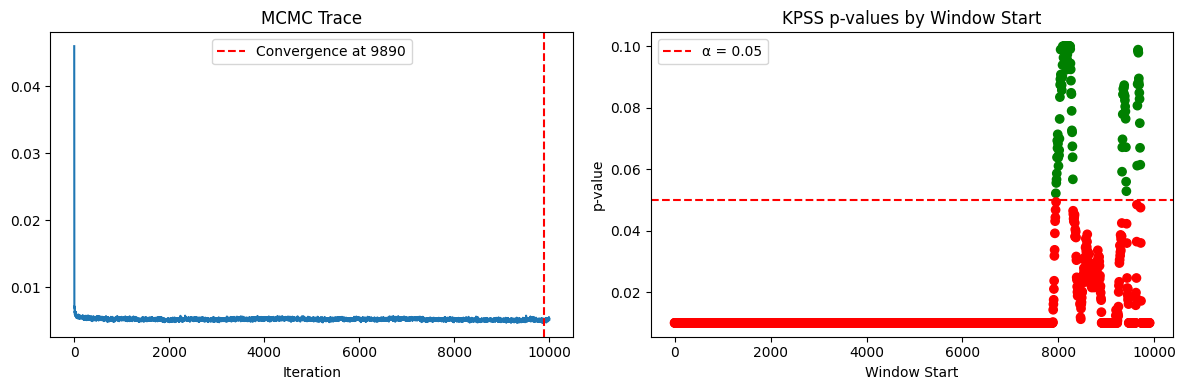

MTMH Chain converged: True
Convergence at iteration: 9890
Rejection rate: 94.75%

RMSE convergence analysis:


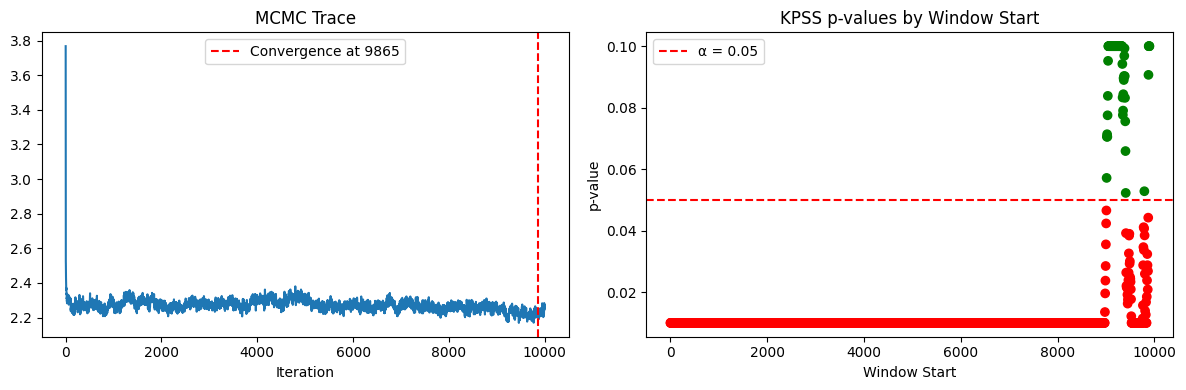

MTMH Chain converged: True
Convergence at iteration: 9865
Rejection rate: 95.66%

--- MTMH Run 4 ---
Sigma convergence analysis:


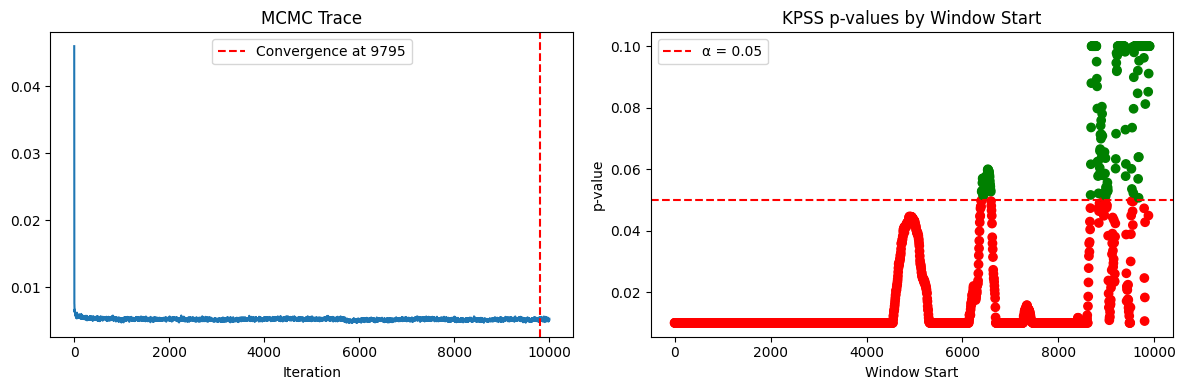

MTMH Chain converged: True
Convergence at iteration: 9795
Rejection rate: 89.45%

RMSE convergence analysis:


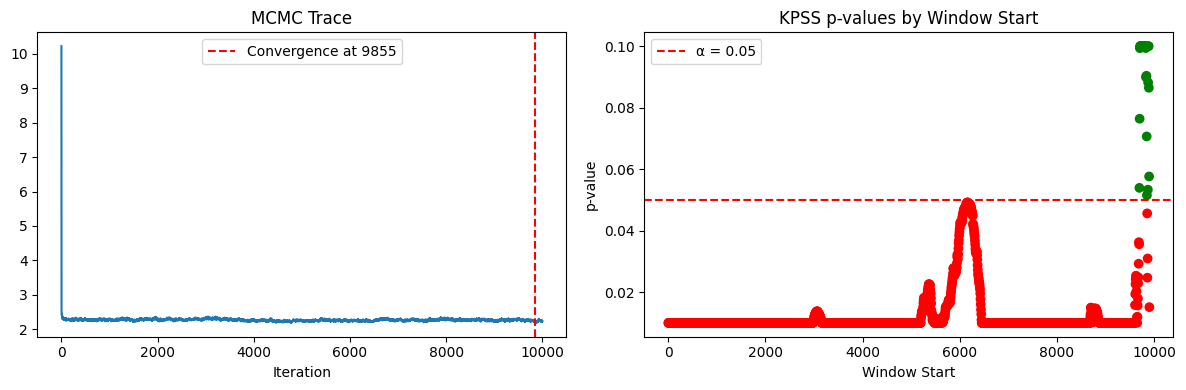

MTMH Chain converged: True
Convergence at iteration: 9855
Rejection rate: 98.08%


In [9]:
# Analyze each run's results and collect statistics
n_runs = 5

# Collect convergence statistics
mtmh_sigma_convergence = []
mtmh_rmse_convergence = []
mtmh_sigma_rates = []
mtmh_rmse_rates = []

# Analyze MTMH BART results
print("=== MTMH BART Analysis ===")
for run_id in range(n_runs):
    print(f"\n--- MTMH Run {run_id} ---")
    
    # Extract data for this run from the combined arrays
    sigmas = experiment_results['mtmh'].item()['sigmas'][run_id]
    rmses = experiment_results['mtmh'].item()['rmses'][run_id]

    print(f"Sigma convergence analysis:")
    convergence_result = segmented_kpss_test(sigmas, window_length=100, step=5, alpha=0.05)
    print(f"MTMH Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_sigma_convergence.append(convergence_result['convergence_iteration'])
    print(f"Rejection rate: {convergence_result['rejection_rate']:.2%}")
    mtmh_sigma_rates.append(convergence_result['rejection_rate'])

    print(f"\nRMSE convergence analysis:")
    convergence_result = segmented_kpss_test(rmses, window_length=100, step=5, alpha=0.05)
    print(f"MTMH Chain converged: {convergence_result['converged']}")
    if convergence_result['converged']:
        print(f"Convergence at iteration: {convergence_result['convergence_iteration']}")
        mtmh_rmse_convergence.append(convergence_result['convergence_iteration'])
    print(f"Rejection rate: {convergence_result['rejection_rate']:.2%}")
    mtmh_rmse_rates.append(convergence_result['rejection_rate'])